In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.model import Model
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import (
    aggregated_dataframe,
    rename_labels,
    rename_entries,
)
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo


      DETECTED LOCAL MACHINE: Test snapshot loaded.


      CONFIG: Setting resolution to 4096.


      CONFIG: Setting snapshot to 127.


      CONFIG: Setting sim_id to 09_18.

yt : [INFO     ] 2023-10-18 16:00:11,872 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-10-18 16:00:11,936 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-10-18 16:00:11,937 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-10-18 16:00:11,937 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-18 16:00:11,938 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-10-18 16:00:11,938 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-18 16:00:11,939 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-10-18 16:00:11,939 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-10-18 16:00:11,940 Parameters: omega_matter 

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Galaxy_components"
save = True

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [8]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    [
        "[Fe/H]",
        "stellar_age",
        "Masses",
    ],
    data_source=sphere_data,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels and components
data = rename_entries(data)
data, labels = rename_labels(data)

## FRACTION OF MASS IN COMPONENTS

In [9]:
data.groupby("Component")["Masses"].sum()

Component
Bulge         1.807907e+10
Halo          2.949425e+09
Thick Disk    6.626075e+09
Thin Disk     3.823580e+10
Name: Masses, dtype: float64

In [10]:
data.groupby("Component")["Masses"].sum() / data["Masses"].sum()

Component
Bulge         0.274381
Halo          0.044763
Thick Disk    0.100562
Thin Disk     0.580294
Name: Masses, dtype: float64

## STELLAR AGE IN COMPONENTS

In [11]:
data.groupby("Component")[labels["stellar_age"]].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,99663.000000,14628.000000,36529.000000,196120.000000
mean,7.794651,8.755310,6.240550,3.440141
std,3.078336,2.711745,3.076973,2.577899
min,0.020130,0.049757,0.020877,0.020130
25%,5.756579,6.559794,4.080674,1.402762
50%,8.248188,8.273015,6.013324,2.910814
75%,9.989825,10.788978,8.249695,4.841416
max,13.462528,13.325122,13.457962,13.448053


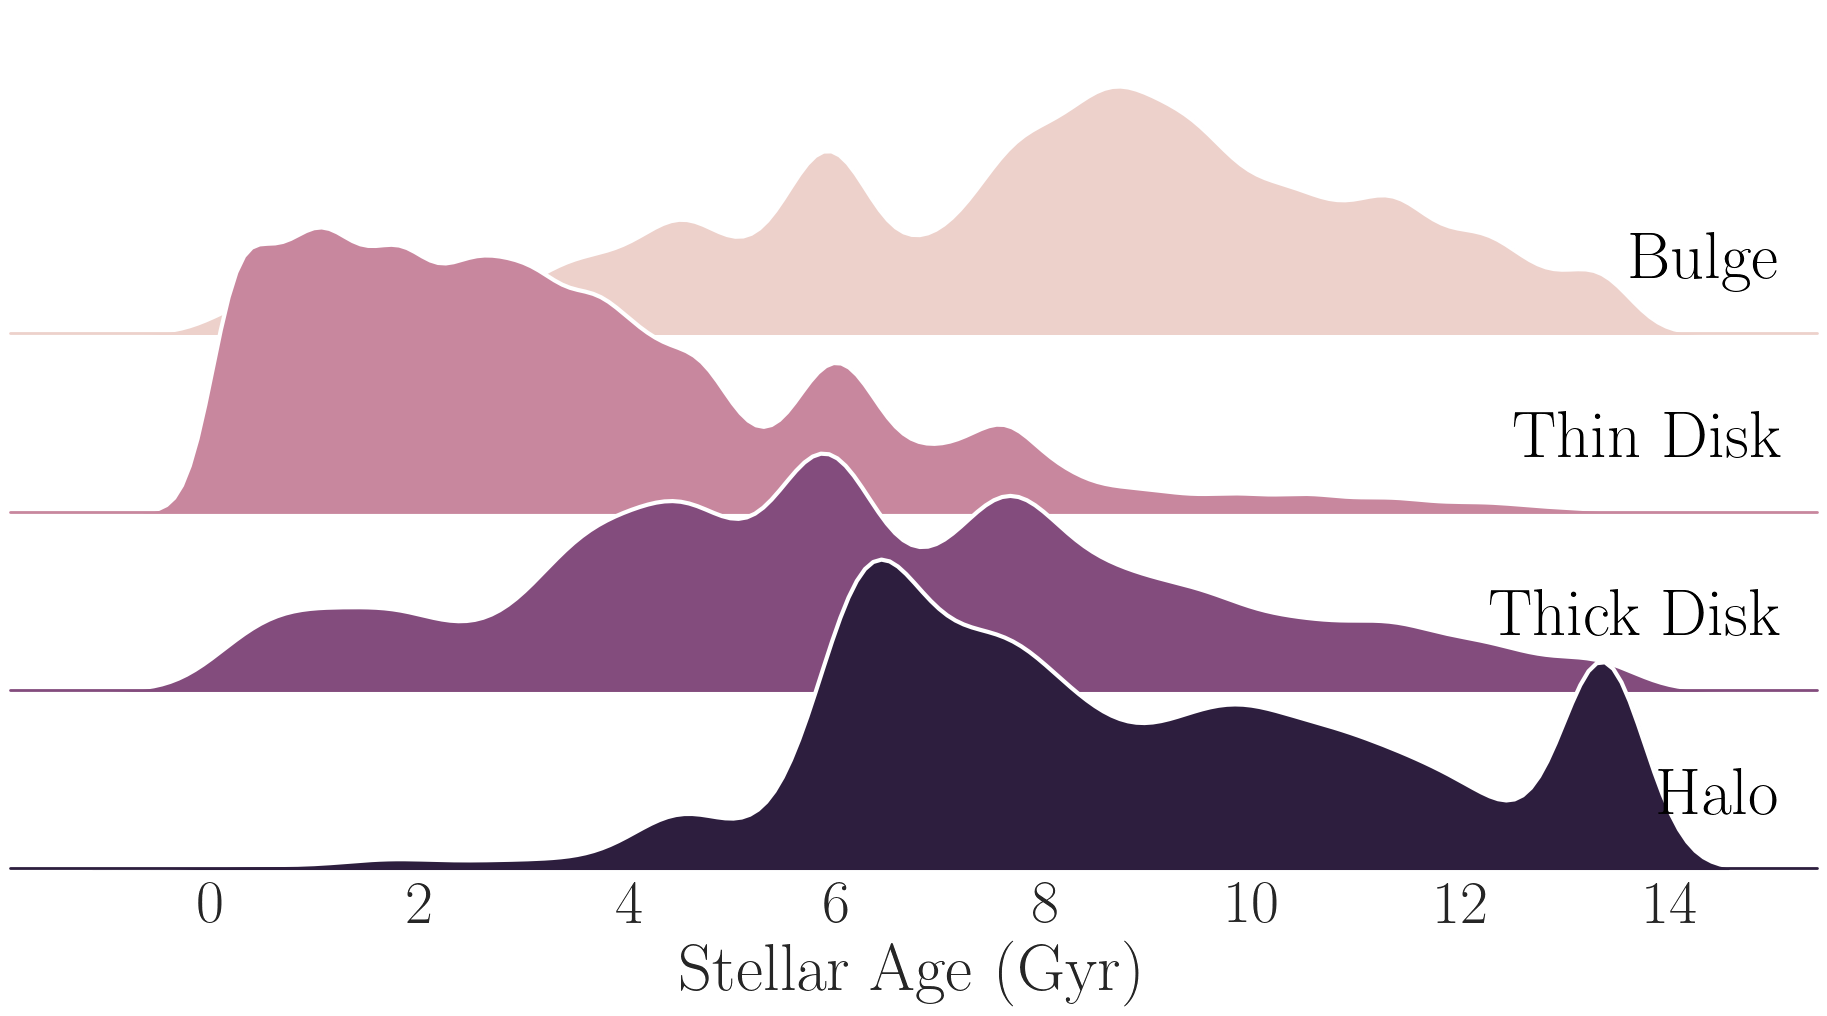

In [12]:
ridgeplot_age = ridgeplot(
    data,
    x=labels["stellar_age"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.98, 0.22],
)
FigureProcessor(ridgeplot_age.figure).save(
    "ridgeplot_age.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## METALLICITY IN COMPONENTS

In [13]:
data.groupby("Component")["[Fe/H]"].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,99663.000000,14628.000000,36529.000000,196120.000000
mean,-0.240405,-0.646267,-0.110302,-0.014277
std,0.457613,0.443302,0.443982,0.309590
min,-2.497246,-2.488860,-2.465924,-2.475818
25%,-0.531653,-0.865720,-0.398377,-0.209704
50%,-0.218829,-0.595721,-0.085696,0.000227
75%,0.087771,-0.344860,0.265233,0.215032
max,0.840895,0.529155,0.719918,0.718245


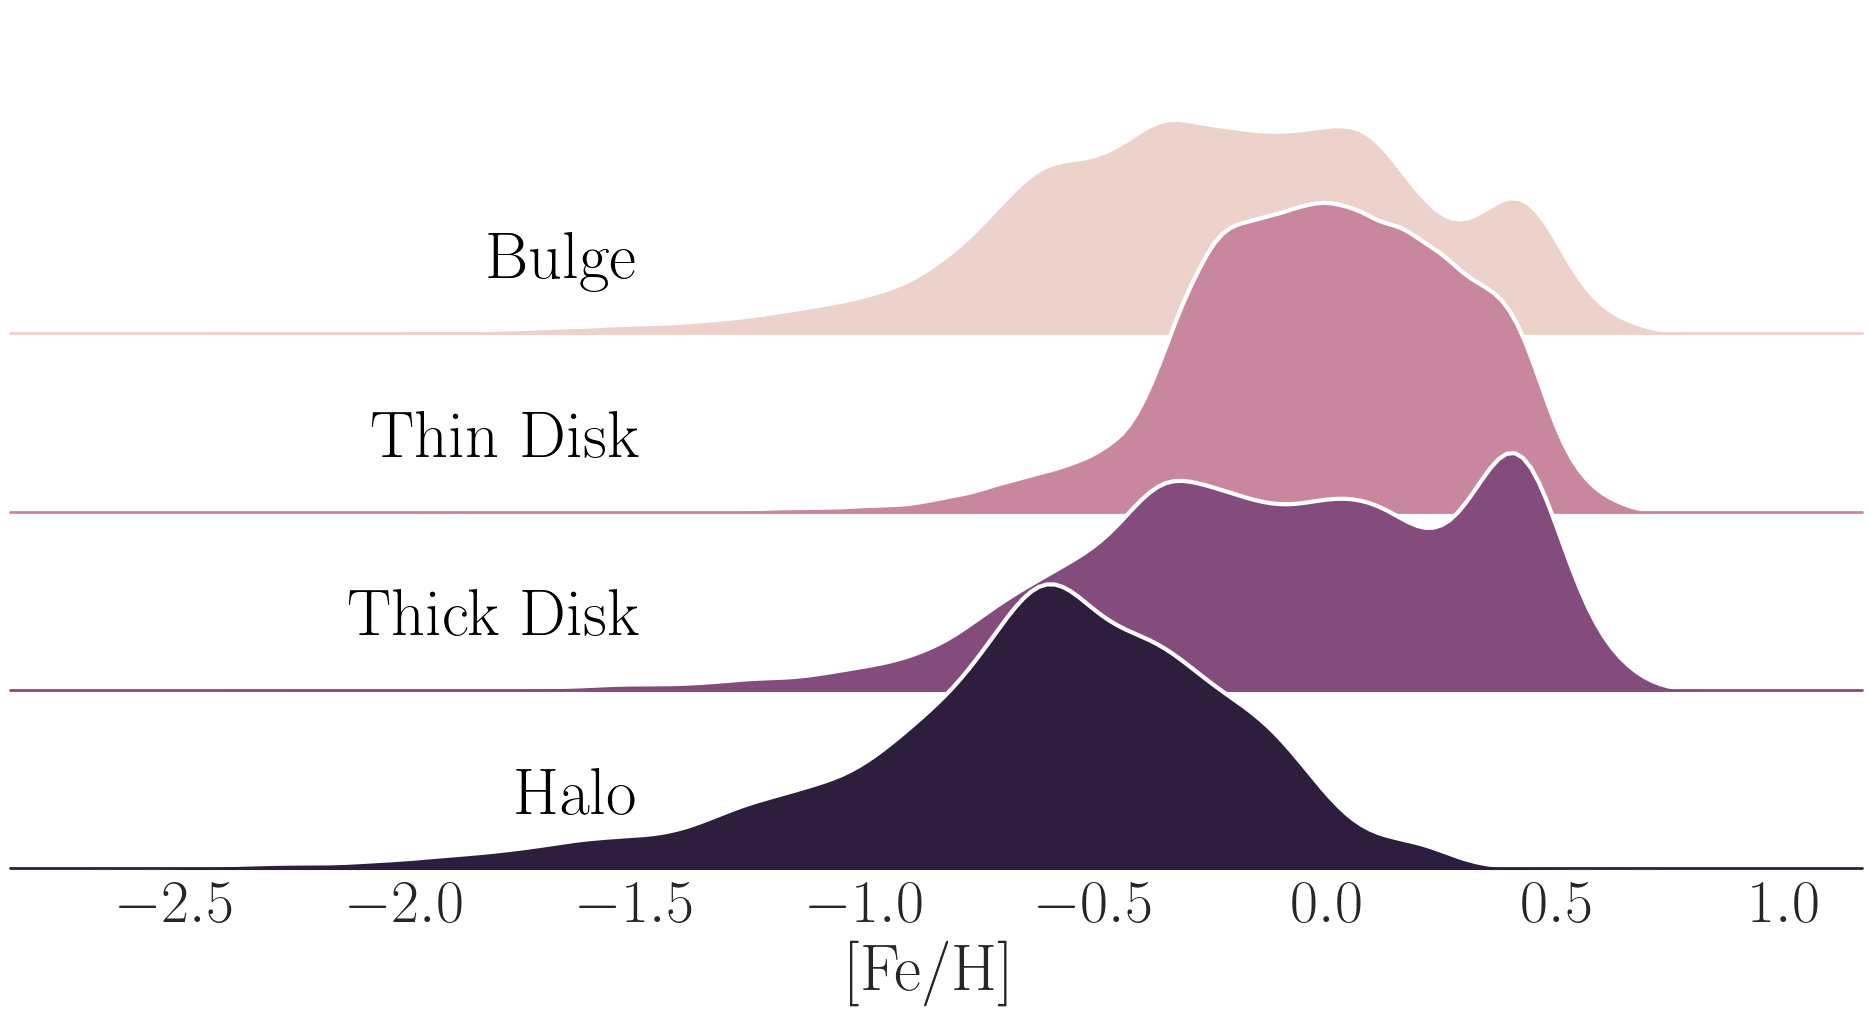

In [14]:
ridgeplot_metallicity = ridgeplot(
    data,
    x=labels["[Fe/H]"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.34, 0.22],
)
FigureProcessor(ridgeplot_metallicity.figure).save(
    "ridgeplot_metallicity.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## PRICIPAL COMPONENTS

In [15]:
variance_ratios = pd.DataFrame(
    np.array(
        [
            calculate_pca(
                sphere_data[component, "particle_position"].to("kpc")
            ).explained_variance_ratio_
            for component in components
        ]
    ).T,
    columns=components,
).T

print("Minor-to-major axis ratio:")
print(variance_ratios[2] / variance_ratios[0])

Minor-to-major axis ratio:
bulge_stars         0.489452
thin_disk_stars     0.071305
thick_disk_stars    0.442515
halo_stars          0.440510
dtype: float64
